In [1]:
import pandas as pd 
import bamboolib as bam
import plotly.express as px
import numpy as np


In [2]:
BusAcc = pd.read_excel(r'/Users/kingced/Desktop/JP Morgan Data For Good/Business Account.xlsx')
BusAcc = BusAcc.loc[~(BusAcc['Created On'] < '2020-12-31')]

In [3]:
Opport = pd.read_excel(r'/Users/kingced/Desktop/JP Morgan Data For Good/Opportunities.xlsx')
Opport = Opport.loc[~(Opport['Created On'] < '2020-12-31')]

In [4]:
ItnOpp = pd.read_excel(r'/Users/kingced/Desktop/JP Morgan Data For Good/Items and Opportunities.xlsx')

In [21]:
# Step: Left Join with BusAcc where Business Account=Business Account
df = pd.merge(Opport, BusAcc, how='left', on=['Business Account'])

In [22]:
df['Occu']=df.groupby('Business Account')['Business Account'].transform('count')

In [23]:
# Step: Select columns
df_4_Model = df[['Business Account','Partner type', 'Class Name', 'Activity sector', 'City', 'Amount received','Estimated amount', 'Type de financement']]
df_4_Model

     Business Account Partner type          Class Name  \
0              C00037      Partner        Headquarters   
1              C01254      Partner  Regional direction   
2              C21512          NaN                 NaN   
3              C21509          NaN                 NaN   
4              C21508          NaN                 NaN   
...               ...          ...                 ...   
5981           C00036      Partner        Headquarters   
5982           C00024      Partner          Foundation   
5983           C00011      Partner        Headquarters   
5984           C00331      Partner          Foundation   
5985           C00331      Partner          Foundation   

                                        Activity sector                 City  \
0     LAW - ECONOMICS - MANAGEMENT - Accounting, Man...                 LYON   
1     INSURANCE - BANKING - Banking, Insurance, Fina...                 LYON   
2                                                   NaN        

No such comm: ef64b89076494f81a1d01b3ba4c7a90b


In [24]:

import pandas as pd; import numpy as np
# Step: Group by and aggregate
df_4_Model = df_4_Model.groupby(['Business Account']).agg({**{'Amount received': ['mean']}, **{col: ['first'] for col in df_4_Model.select_dtypes(['object']).columns}})
df_4_Model.columns = ['_'.join(multi_index) for multi_index in df_4_Model.columns.ravel()]
df_4_Model = df_4_Model.reset_index()

# Step: Drop columns
df_4_Model = df_4_Model
df=df_4_Model

In [25]:
import pandas as pd; import numpy as np
# Step: Replace missing value with 0 in 'Amount received_mean'
df['Amount received_mean'] = df['Amount received_mean'].replace(np.nan, 0)

df

     Business Account  Amount received_mean Business Account_first  \
0              C00001                4800.0                 C00001   
1              C00002                 183.0                 C00002   
2              C00004                9000.0                 C00004   
3              C00005                   0.0                 C00005   
4              C00011                 389.0                 C00011   
...               ...                   ...                    ...   
2058           C21527                   0.0                 C21527   
2059           C21528                   0.0                 C21528   
2060           C21529                   0.0                 C21529   
2061           C21530                   0.0                 C21530   
2062           C21537                   0.0                 C21537   

     Partner type_first Class Name_first  \
0               Partner       Foundation   
1                  None             None   
2               Partner    

No such comm: de9a53569e7149cb83722e768465a204


In [26]:
df["City_first"] = df["City_first"].str.capitalize()
df 

     Business Account  Amount received_mean Business Account_first  \
0              C00001                4800.0                 C00001   
1              C00002                 183.0                 C00002   
2              C00004                9000.0                 C00004   
3              C00005                   0.0                 C00005   
4              C00011                 389.0                 C00011   
...               ...                   ...                    ...   
2058           C21527                   0.0                 C21527   
2059           C21528                   0.0                 C21528   
2060           C21529                   0.0                 C21529   
2061           C21530                   0.0                 C21530   
2062           C21537                   0.0                 C21537   

     Partner type_first Class Name_first  \
0               Partner       Foundation   
1                  None             None   
2               Partner    

No such comm: 5e31e09a5deb41d395fce8769f46cca5


In [27]:
cities_to_select = ['Lyon', 'Paris', 'Marseille'] 
df['City_first'] = df['City_first'].apply(lambda x: x if x in cities_to_select else 'Others')

In [28]:
import pandas as pd; import numpy as np
# Step: OneHotEncode column(s) Partner type_first, Class Name_first, Activity sector_first, City_first, Type de financement_first
df = pd.get_dummies(df, columns=['Partner type_first', 'Class Name_first', 'Activity sector_first', 'City_first', 'Type de financement_first'], drop_first=False, dummy_na=False)

import pandas as pd; import numpy as np
# Step: Drop columns
df = df.drop(columns=['Business Account', 'Business Account_first'])

# Step: Set values of Amount received_mean to 1 where Amount received_mean != 0 and otherwise to 0
tmp_condition = df['Amount received_mean'] != 0
df.loc[tmp_condition, 'Amount received_mean'] = 1
df.loc[~tmp_condition, 'Amount received_mean'] = 0

df

     Business Account  Amount received_mean Business Account_first  \
0              C00001                4800.0                 C00001   
1              C00002                 183.0                 C00002   
2              C00004                9000.0                 C00004   
3              C00005                   0.0                 C00005   
4              C00011                 389.0                 C00011   
...               ...                   ...                    ...   
2058           C21527                   0.0                 C21527   
2059           C21528                   0.0                 C21528   
2060           C21529                   0.0                 C21529   
2061           C21530                   0.0                 C21530   
2062           C21537                   0.0                 C21537   

      Partner type_first_Inactive partner  \
0                                       0   
1                                       0   
2                       

### Model

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import KFold,cross_val_score,cross_val_predict
from sklearn.neural_network import MLPRegressor
import time

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [46]:
X = df.drop(['Amount received_mean'], axis=1)
Y = df['Amount received_mean']

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

## Run the best model 

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.model_selection import KFold,cross_val_score
import time

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [50]:
clfs = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=1), 
    'BAG': BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1),n_estimators=100,random_state=1),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'CART': DecisionTreeClassifier(criterion='gini',random_state=1),
    'ID3': DecisionTreeClassifier(criterion='entropy',random_state=1),
    'Stumb': DecisionTreeClassifier(criterion='gini',max_depth=1,random_state=1),
    'MLP': MLPClassifier(hidden_layer_sizes=(20,10),random_state=1)
}

In [54]:
y_train.value_counts()

1.0    1007
0.0     643
Name: Amount received_mean, dtype: int64

In [52]:
def run_classifieurs(X,Y):
    kf = KFold(n_splits=10, shuffle=True, random_state=1) 
    for i in clfs:
        clf = clfs[i]
        debut=time.time()
        cv_acc = cross_val_score(clf, X, Y, cv=kf,scoring='accuracy')
        fin=time.time()
        print("Accuracy for {0} is: {1:.3f} +/- {2:.3f} en {3:.3f}s".format(i,
                                                                            np.mean(cv_acc),
                                                                            np.std(cv_acc),fin-debut))

In [53]:
run_classifieurs(X_train,y_train)

Accuracy for RF is: 0.736 +/- 0.033 en 0.838s
Accuracy for BAG is: 0.733 +/- 0.037 en 1.790s
Accuracy for KNN is: 0.699 +/- 0.033 en 0.083s
Accuracy for CART is: 0.721 +/- 0.037 en 0.050s
Accuracy for ID3 is: 0.722 +/- 0.034 en 0.057s
Accuracy for Stumb is: 0.655 +/- 0.027 en 0.039s
Accuracy for MLP is: 0.721 +/- 0.033 en 5.348s


scoring for Random Forest is: 73.850 en 0.122s


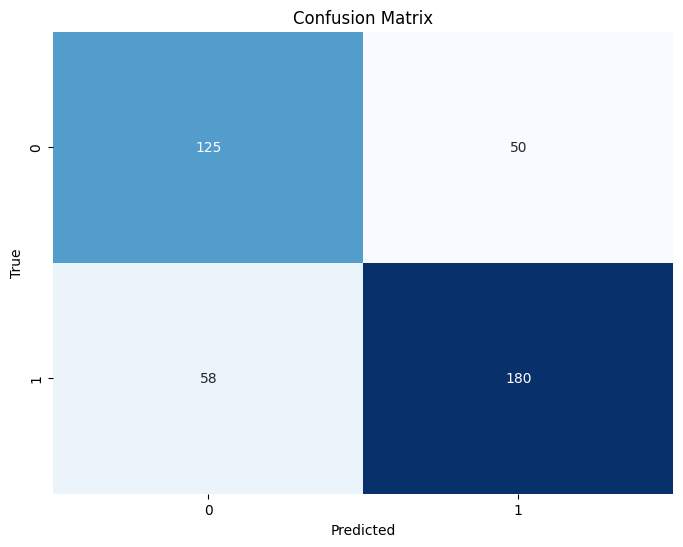

Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.71      0.70       175
         1.0       0.78      0.76      0.77       238

    accuracy                           0.74       413
   macro avg       0.73      0.74      0.73       413
weighted avg       0.74      0.74      0.74       413



In [61]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

mod=RandomForestClassifier(n_estimators=100, random_state=1)
i='Random Forest'
debut = time.time()

mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
scoring = accuracy_score(y_test, y_pred)

fin = time.time()
print("scoring for {0} is: {1:.3f} en {2:.3f}s".format(i,scoring*100, fin - debut))

# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)